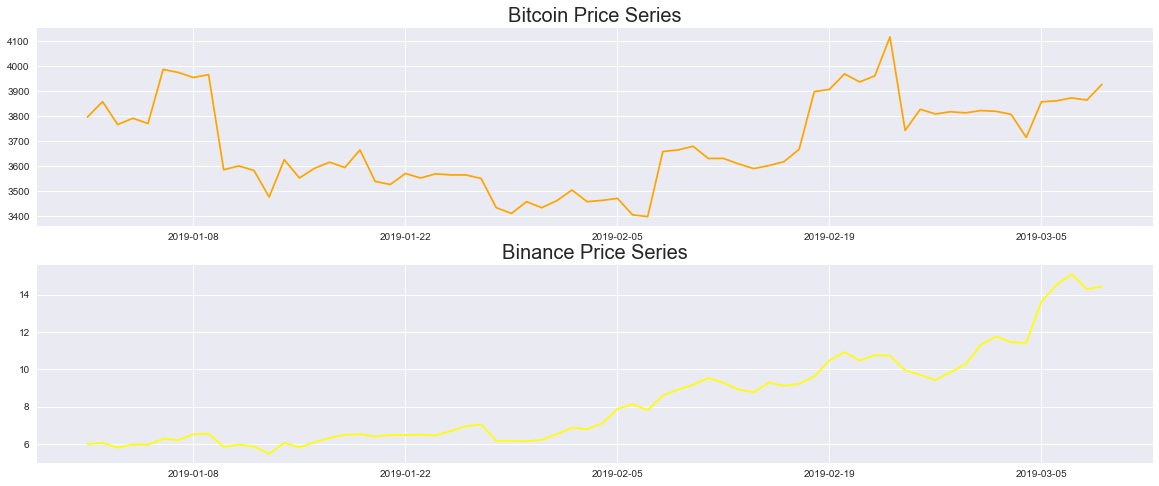

In [177]:
from binance.client import Client
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

_binance_config_file = 'binance_api.json'

def load_config():
    with open(_binance_config_file, 'r') as read_file:
        return json.load(read_file)

def create_client():
    cfg = load_config()
    return Client(cfg['API Key'], cfg['Secret Key'])

def get_daily_hist_ohlcv(client, ticker, start_date):
    raw_data = client.get_historical_klines(ticker, Client.KLINE_INTERVAL_1DAY, start_date)
    df = pd.DataFrame(raw_data).drop([6,7,8,9,10,11], axis=1)
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df['Date'] = [datetime.utcfromtimestamp(ts/1000).strftime('%m-%d-%Y') for ts in df['Date']]
    df.index = pd.to_datetime(df['Date'])
    
    for col in df.loc[:,'Open':].columns:
        df[col] = pd.to_numeric(df[col])

    return df.loc[:,'Open':]

def main():
    
    # Create Binance API client
    client = create_client()

    # Set start date
    start_date = '01-01-2019'
    
    # Get BNB price series
    bnbusdt = get_daily_hist_ohlcv(client, 'BNBUSDT', start_date)
    
    # Get BTC price series
    btcusdt = get_daily_hist_ohlcv(client, 'BTCUSDT', start_date)

    # Plot price series
    fig, ax = plt.subplots(2,1, figsize=(20,8))
    ax[0].plot(btcusdt['Close'], 'orange')
    ax[0].set_title('Bitcoin Price Series', fontsize=20)
    ax[1].plot(bnbusdt['Close'], 'yellow')
    ax[1].set_title('Binance Price Series', fontsize=20)
    plt.show()

if __name__ == '__main__':
    main()
